# TODO: 概要

# ライブラリのインポート

In [29]:
import os
import json
import asyncio
import datetime

from dotenv import load_dotenv, find_dotenv

from IPython.display import Image, display

from azure.identity.aio import DefaultAzureCredential
from azure.ai.agents.models import (
    FileInfo, FileSearchTool, VectorStore,
    CodeInterpreterTool, FilePurpose,
    ListSortOrder
)

from semantic_kernel.agents import (
    ChatCompletionAgent, ChatHistoryAgentThread,
    AzureAIAgent, AzureAIAgentSettings, AzureAIAgentThread
)
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.connectors.mcp import MCPStreamableHttpPlugin
from semantic_kernel.contents import (
    ChatMessageContent, FunctionCallContent, FunctionResultContent, AuthorRole, TextContent
)


# 環境変数の取得

In [30]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")
AZURE_OPENAI_ENDPOINT=os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY=os.getenv("AZURE_OPENAI_API_KEY")

FOUNDRY_FILE_SEARCH_AGENT_ID=os.getenv("FOUNDRY_FILE_SEARCH_AGENT_ID")

# ユーティリティ関数

In [31]:
async def agent_run_outputs(thread_id, agents_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    async for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")

        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                await agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))


# プロジェクトクライアントの初期化

In [32]:
# AzureAIAgent クライアントを初期化
project_client = AzureAIAgent.create_client(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# 1. 作成済み Foundry Agent を利用する方法
※ 先ほど作成したエージェントを取得します。

## 1-1. Foundry Agent の取得

In [33]:
file_search_agent_definition = await project_client.agents.get_agent(agent_id=FOUNDRY_FILE_SEARCH_AGENT_ID)

## 1-2. Semaitic Kernel Agent の初期化

In [34]:
agent = AzureAIAgent(
    client=project_client,
    definition=file_search_agent_definition,
)

## 1-3. スレッドの作成

In [35]:
thread = AzureAIAgentThread(
    client=project_client
)
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: None


## 1-4. レスポンスを取得

In [36]:
message= (
    "パソコンの保障プランでもっとも安いプランは？"
)

response = await agent.get_response(
    messages=[message],
    thread=thread,
)

await agent_run_outputs(thread.id, project_client.agents)

USER: パソコンの保障プランでもっとも安いプランは？
ASSISTANT: パソコンの保障プランでもっとも安いプランは「1年プラン」で、料金は税込10,000円です。内容としては、修理費用全額カバー、代替機の提供（最短3営業日）、論理障害によるデータ復旧、24時間365日のサポートなどが含まれています【4:3†パソコン保障プラン.html】。


# 2. Foundry Agent の作成方法

## 2-1. プラグインの作成

In [43]:
code_interpreter = CodeInterpreterTool()

## 2-2. Foundry Agent の作成

In [53]:
code_interpreter_agent_definition = await project_client.agents.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたはコードインタープリターエージェントです。"
        "Pythonコードを実行し、結果を返します。"
        "高度な分析やグラフの出力が得意です。"
    ),
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

## 2-3. Semantic Kernel Agent の作成

In [48]:
agent = AzureAIAgent(
    client=project_client,
    definition=code_interpreter_agent_definition,
)

## 2-4. スレッドの作成

In [49]:
thread = AzureAIAgentThread(
    client=project_client
)
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: None


## 2-5. レスポンスの取得

USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。また、投資せずに貯蓄した場合と比較できるようグラフを出力してください。ラベルやタイトルは英語で出力してください。
ASSISTANT: まず、投資した場合の資産額を複利計算で求め、同時に追加投資をせずに貯蓄だけ行った場合（つまり利回り0%）も並べます。そして、両者をプロットしたグラフを作成します。

条件:
- 初期投資: 1,000,000円
- 年利: 3.5%
- 追加投資: 年10万円（20回）
- 投資期間: 20年

計算式（年利で追加入金ありの複利運用）：
資産額 \(A = P(1+r)^n + \sum_{k=1}^{n} C(1+r)^{n-k} \)  
P: 初期投資, r: 年利率, C: 毎年の追加, n: 年数

投資しない場合は、毎年10万円追加するのみ。

計算＆グラフを実行します。
ASSISTANT: 20年間、年利回り3.5%で毎年10万円ずつ追加入金した場合の最終的な資産額は **4,817,757円**（円単位で四捨五入）です。

一方、利息なしで20年間単純に貯蓄した場合の資産額は **3,000,000円** となります。

上記のグラフは、投資と貯蓄の場合の資産推移を比較したものです。
Saved image: assistant-XxGvgETnxm3vN66tu79oi2_image_file.png


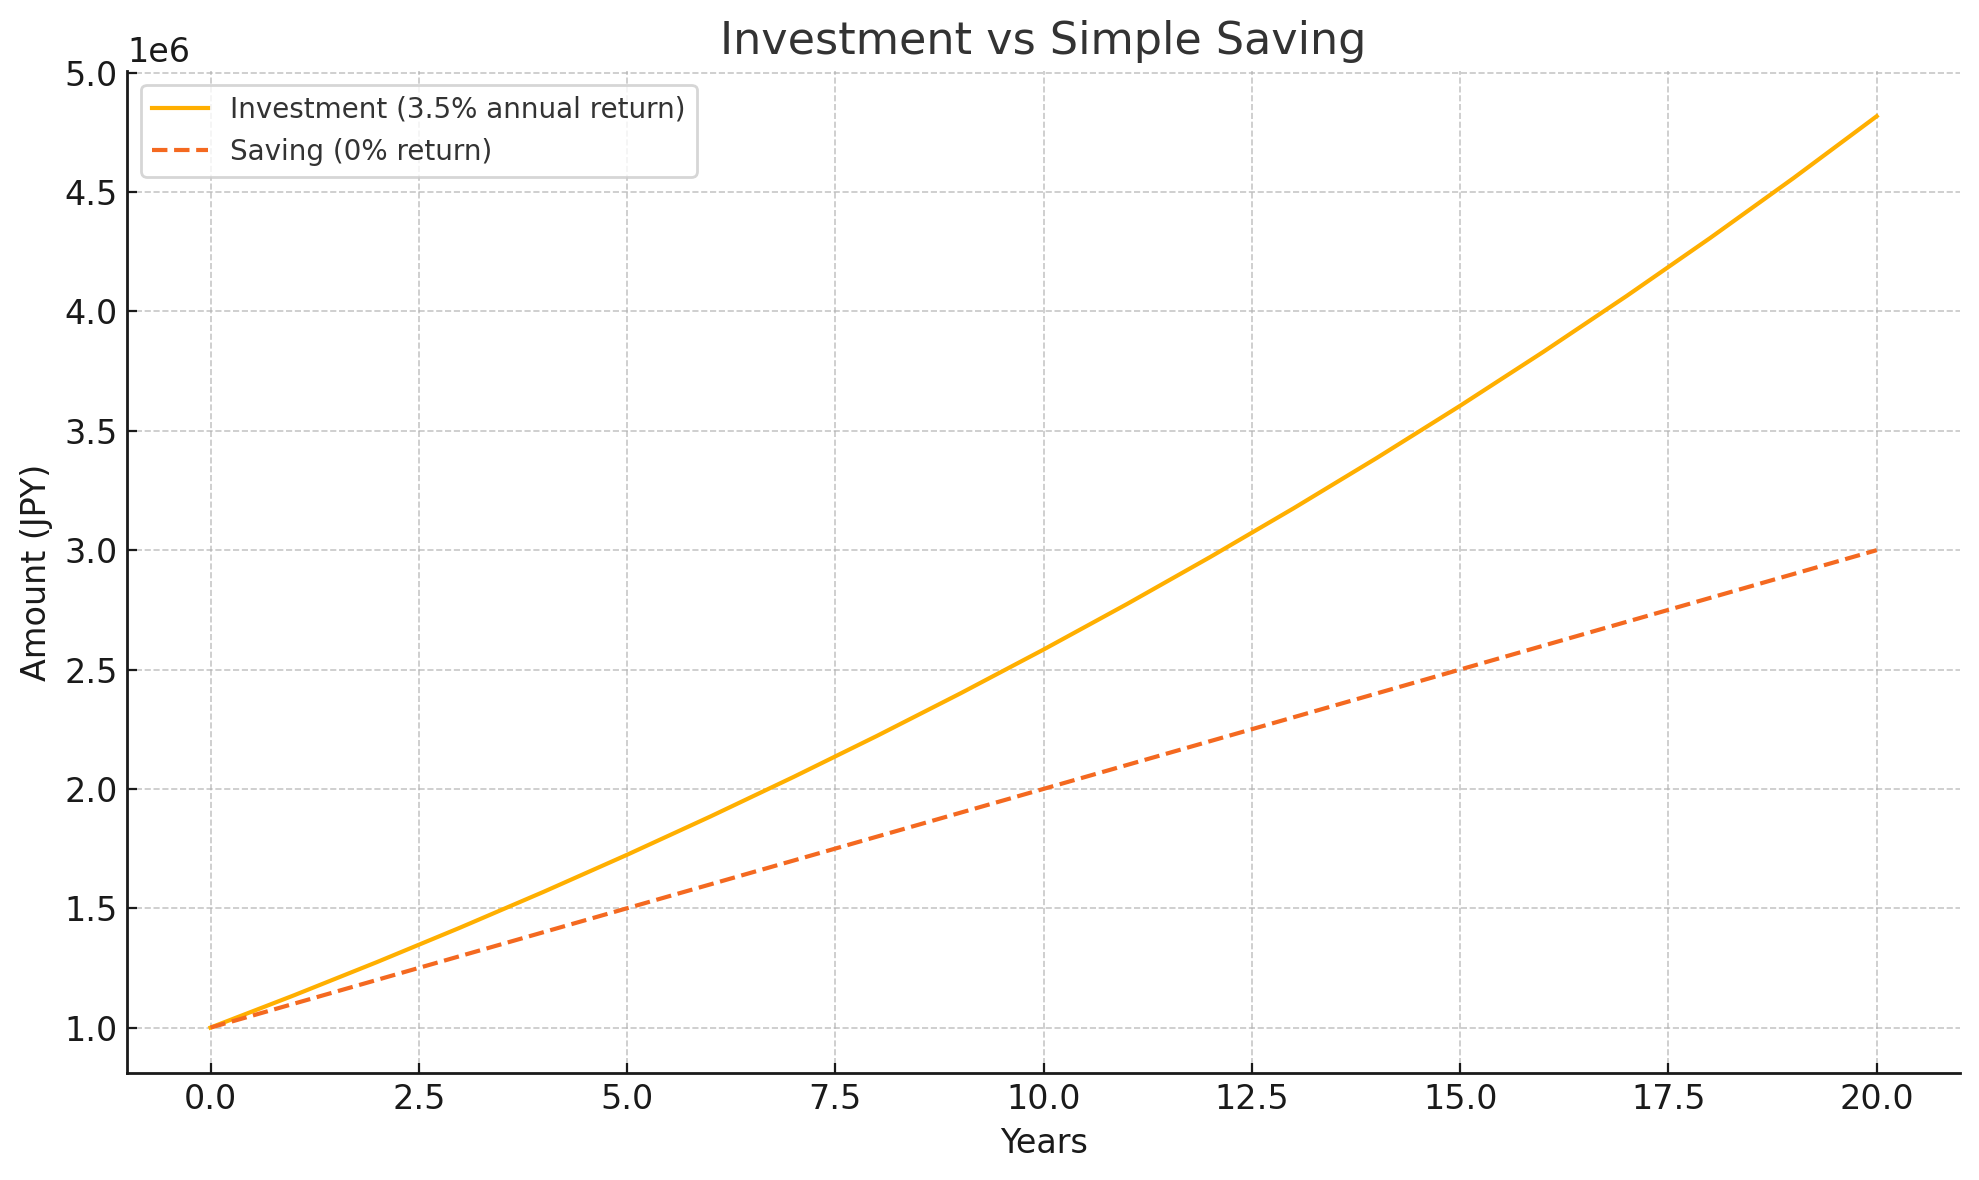

In [50]:
message= (
    "初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を"
    "20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。"
    "また、投資せずに貯蓄した場合と比較できるようグラフを出力してください。ラベルやタイトルは英語で出力してください。"
)


response = await agent.get_response(
    messages=[message],
    thread=thread,
)

await agent_run_outputs(thread.id, project_client.agents)

# Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続の Connected Agents のハンズオン演習で使用するため永続化します。

In [54]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent_definition.id

# .envファイルのパスを自動探索
env_path = find_dotenv()  # 見つからなければ''を返す
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_PhSwcdYKIPPJJ1PForbcRZa0" を追記しました。


In [52]:
code_interpreter_agent_definition

{'id': 'asst_JaBWXUdpUTK2xoXFtsbE7sYh', 'object': 'assistant', 'created_at': 1753695784, 'name': None, 'description': None, 'model': 'gpt-4.1', 'instructions': 'あなたはコードインタープリターエージェントです。Pythonコードを実行し、結果を返します。高度な分析やグラフの出力が得意です。', 'tools': [{'type': 'code_interpreter'}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {'code_interpreter': {'file_ids': []}}, 'metadata': {}, 'response_format': 'auto'}